# DECODER

In [1]:
import warnings
import numpy as np
from tensorflow.keras.layers import Input, Dense, Concatenate, Conv2DTranspose, Flatten, Reshape
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt


warnings.filterwarnings('ignore')

2023-07-24 22:48:54.745407: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 22:48:55.150622: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
latent_dim = 128 # latent space size
n_cat = 4

In [3]:
dec_inp_latent_vector = Input(shape=(latent_dim), name="input_latent_vector")
decoder_inp_label = Input(shape=(n_cat), name = "input_label")
dec_concat = Concatenate(name="decoder_concat")([dec_inp_latent_vector, decoder_inp_label])

decoder_hidden = Dense(512, activation="relu", name="dec_hidden_layer")(dec_concat)
decoder_hidden = Dense(16*16*256, activation="relu", name="dec_hidden_layer2")(decoder_hidden)
reshaped = Reshape(target_shape=(16,16,256), name="dec_reshape")(decoder_hidden)

# convolutionals block
dec_conv1 = Conv2DTranspose(filters=256, kernel_size=3, padding="same", activation='relu', name="dec_conv1")(reshaped)  #  skip-connection # 16x16
dec_conv2 = Conv2DTranspose(filters=128, kernel_size=3, padding="same", activation='relu', name="dec_conv2")(dec_conv1) # 16x16
dec_conv3 = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding="same", activation='relu', name="dec_conv3")(dec_conv2) #  skip-connection 32x32
dec_conv4 = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="same", activation="relu", name="dec_conv4")(dec_conv3) # 68x68

dec_output_img = Conv2DTranspose(filters=1, kernel_size=3, strides=2, padding='same', name="output_img")(dec_conv4)
dec_output_img = Flatten(name="flattened_img")(dec_output_img)

decoder = Model(inputs=[dec_inp_latent_vector, decoder_inp_label], outputs=dec_output_img)

2023-07-24 22:49:00.478032: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-24 22:49:00.497388: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-24 22:49:00.497574: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
decoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_latent_vector (InputLaye  [(None, 128)]       0           []                               
 r)                                                                                               
                                                                                                  
 input_label (InputLayer)       [(None, 4)]          0           []                               
                                                                                                  
 decoder_concat (Concatenate)   (None, 132)          0           ['input_latent_vector[0][0]',    
                                                                  'input_label[0][0]']            
                                                                                              

In [5]:
decoder.load_weights("model_checkpoints/checkpoint.h5", by_name=True, skip_mismatch=True)

# Prediction

2023-07-24 22:49:08.845932: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-24 22:49:08.924573: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


1/1 [==============================] - 1s 1s/step


2023-07-24 22:49:09.358881: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-24 22:49:09.359451: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-24 22:49:09.359463: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Couldn't invoke ptxas --version
2023-07-24 22:49:09.359854: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-24 22:49:09.359885: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:317] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


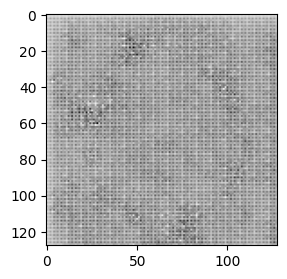

In [6]:
z = np.zeros(shape=(1, latent_dim))  # latent vector
label = np.array([[0, 1, 0, 0]])  # label in one hot encoding
plt.figure(figsize=(3, 3))
plt.imshow(decoder.predict([z, label]).reshape(128, 128), cmap=plt.cm.gray)
plt.show()